In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
from torch import nn
import random

## Step 1: 載入 ARC 資料

In [2]:
with open('arc-prize-2025/arc-agi_training_challenges.json', 'r') as f:
    challenges = json.load(f)

with open('arc-prize-2025/arc-agi_training_solutions.json', 'r') as f:
    solutions = json.load(f)

print(f"Total {len(challenges)} training tasks")
print(f"Example task IDs: {list(challenges.keys())[:5]}")

Total 1000 training tasks
Example task IDs: ['00576224', '007bbfb7', '009d5c81', '00d62c1b', '00dbd492']


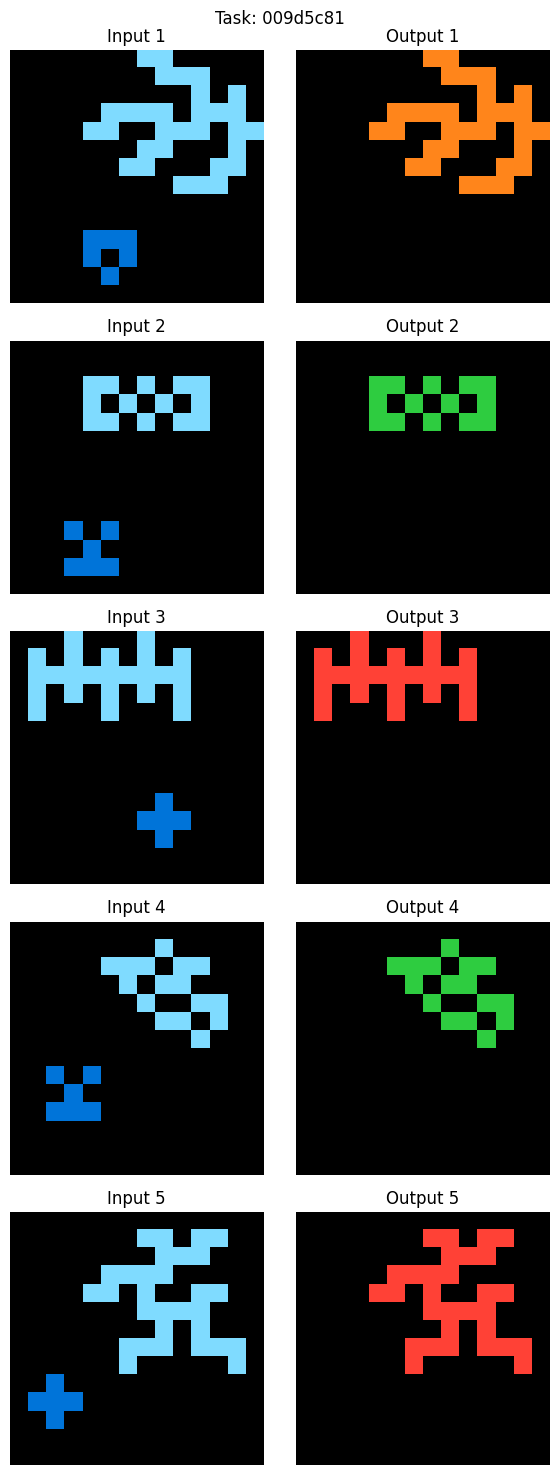

In [3]:
from plot import visualize_task

sample_task_id = list(challenges.keys())[2]
visualize_task(challenges,sample_task_id)

## Step 2: 建立 VSA 空間

VSA 使用兩種空間：
1. **SP 空間 (Semantic Pointer)**: 用於表示離散概念（如顏色）
2. **SSP 空間 (Spatial Semantic Pointer)**: 用於表示連續空間（如座標位置）

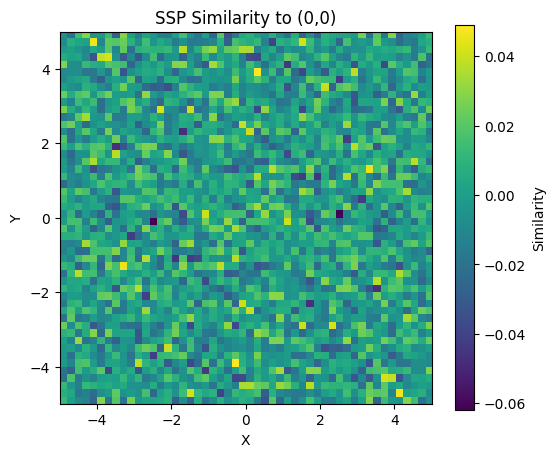

In [4]:
from vsa import SimpleSSPSpace
import nengo_spa as spa

from config import N_DIMENSIONS, SSP_SPACE, colour_tags, COLOUR_SPS

# 測試 SSP 編碼
point1 = SSP_SPACE.encode([0, 0]).flatten()
point2 = SSP_SPACE.encode([1, 0]).flatten()
point3 = SSP_SPACE.encode([5, 5]).flatten()

# 視覺化 SSP 相似度
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
origin = SSP_SPACE.encode([0, 0]).flatten()

xs = np.linspace(-5, 5, 50)
ys = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(xs, ys)
coords = np.vstack([X.ravel(), Y.ravel()]).T
ssps = SSP_SPACE.encode(coords)
similarities = ssps @ origin

im = ax.imshow(similarities.reshape(50, 50), extent=[-5, 5, -5, 5], 
               origin='lower', cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('SSP Similarity to (0,0)')
plt.colorbar(im, ax=ax, label='Similarity')
plt.show()

## Step 3: 物件偵測與編碼

將網格中的物件編碼為三個 VSA 向量：
- **顏色向量**: 查表取得
- **中心向量**: 用 SSP 編碼邊界框中心
- **形狀向量**: 所有像素位置 bundle 後 bind 中心的逆

In [5]:
from object import detect_objects

# 測試物件偵測
sample_task = challenges[sample_task_id]
sample_input = np.array(sample_task['train'][0]['input'])
detected_objects = detect_objects(sample_input)
print(f"Get {len(detected_objects)} objects")

Get 2 objects


In [6]:
from object import create_arc_objects

# 測試物件編碼
sample_input = sample_task['train'][0]['input']
sample_output = sample_task['train'][0]['output']

input_objects = create_arc_objects(sample_input)
output_objects = create_arc_objects(sample_output)

print(f"Input : {len(input_objects)}")
print(f"Output : {len(output_objects)}")

# 顯示物件相似度
if input_objects and output_objects:
    print(f"\n First Pair:")
    sims = input_objects[0].get_similarity_to(output_objects[0])
    print(f"  colour similarity: {sims[0]:.4f}")
    print(f"  centre similarity: {sims[1]:.4f}")
    print(f"  shape similarity: {sims[2]:.4f}")

Input : 2
Output : 1

 First Pair:
  colour similarity: 0.0032
  centre similarity: 1.0000
  shape similarity: 1.0000


## Step 4: 計算相似度啟發式

分析哪個屬性（顏色/中心/形狀）最能區分不同的操作。

Total 2  input-output pairs

Pair 1:
  colour weight: 1.0000
  centre weight: 0.0000
  shape weight: 0.0000

Pair 2:
  colour weight: 0.3400
  centre weight: 0.3363
  shape weight: 0.3237

Global average weights:
  colour weight: 0.6700
  centre weight: 0.1681
  shape weight: 0.1619


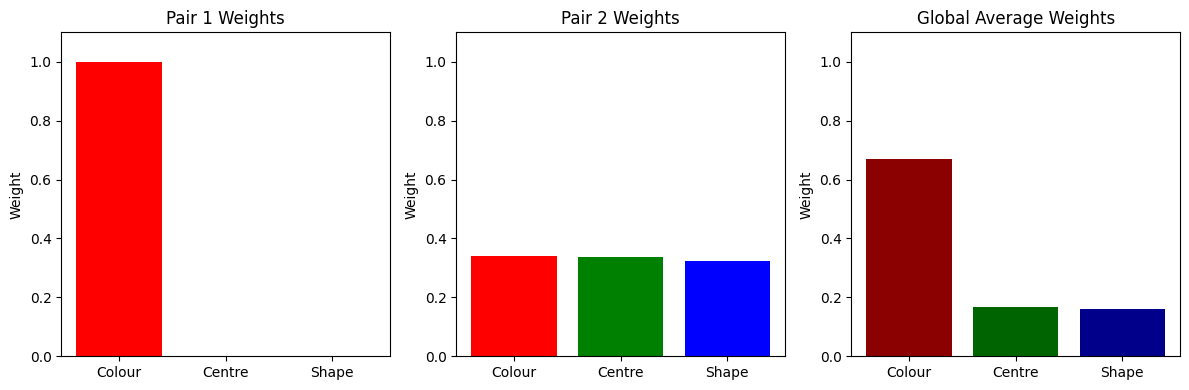

In [7]:
from object_predictor import compute_similarity_heuristic, compute_global_weights

# 測試相似度啟發式
if input_objects and output_objects:
    # 計算每對配對的權重
    weights_list, matched_pairs = compute_similarity_heuristic(input_objects, output_objects)

    print(f"Total {len(matched_pairs)}  input-output pairs\n")

    for i, (in_obj, out_obj, weights) in enumerate(matched_pairs):
        print(f"Pair {i+1}:")
        print(f"  colour weight: {weights[0]:.4f}")
        print(f"  centre weight: {weights[1]:.4f}")
        print(f"  shape weight: {weights[2]:.4f}")
        print()
    
    # 計算全域權重（平均）
    global_weights = compute_global_weights(input_objects, output_objects)
    print(f"Global average weights:")
    print(f"  colour weight: {global_weights[0]:.4f}")
    print(f"  centre weight: {global_weights[1]:.4f}")
    print(f"  shape weight: {global_weights[2]:.4f}")
    
    # 視覺化每對配對的權重
    if len(matched_pairs) > 0:
        n_plots = len(matched_pairs) + 1  # 配對數 + 全域權重
        fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
        
        # 確保 axes 是可迭代的列表
        if n_plots == 1:
            axes = [axes]
        else:
            axes = list(axes.flatten())
        
        for i, (_, _, weights) in enumerate(matched_pairs):
            axes[i].bar(['Colour', 'Centre', 'Shape'], weights, color=['red', 'green', 'blue'])
            axes[i].set_ylabel('Weight')
            axes[i].set_title(f'Pair {i+1} Weights')
            axes[i].set_ylim(0, 1.1)
        
        # 最後一個顯示全域權重
        axes[-1].bar(['Colour', 'Centre', 'Shape'], global_weights, color=['darkred', 'darkgreen', 'darkblue'])
        axes[-1].set_ylabel('Weight')
        axes[-1].set_title('Global Average Weights')
        axes[-1].set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.show()

## Step 5: Operation Predictor

訓練一個神經網路來預測每個物件應該套用哪個操作。

Train data: 10 objects
Operation distribution: {'reshape': 2, 'recolour': 8}

Computed weights: colour=0.696, centre=0.171, shape=0.133

Training Recolour Predictor...


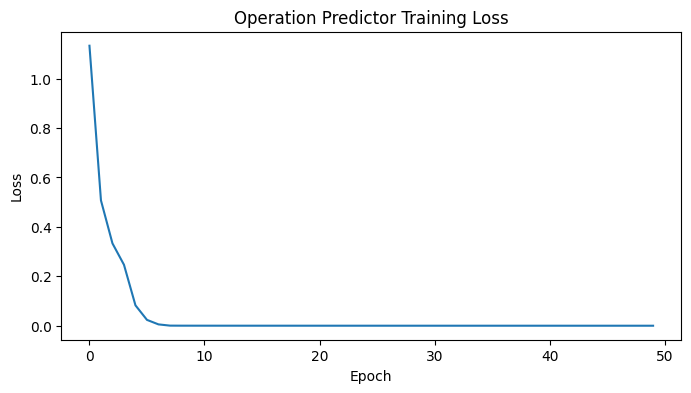


Testing predictions:
  Object 0: Predicted=1.000, Actual=1.0
  Object 1: Predicted=1.000, Actual=1.0
  Object 2: Predicted=1.000, Actual=1.0


In [8]:
from object_predictor import OperationPredictor
from dataloader import prepare_training_data
from train import train_operation_predictor

# 訓練 Operation Predictor（示範用簡單任務）
sample_task = challenges[sample_task_id]

try:
    input_objs, output_objs, ops = prepare_training_data(sample_task)
    
    if input_objs:
        print(f"Train data: {len(input_objs)} objects")
        print(f"Operation distribution: {dict((op, ops.count(op)) for op in set(ops))}")

        # 計算權重（使用全域權重）
        weights = compute_global_weights(input_objs, output_objs)
        print(f"\nComputed weights: colour={weights[0]:.3f}, centre={weights[1]:.3f}, shape={weights[2]:.3f}")

        if 'recolour' in ops:
            predictor = OperationPredictor(N_DIMENSIONS, weights)
            labels = [1.0 if op == 'recolour' else 0.0 for op in ops]

            print(f"\nTraining Recolour Predictor...")
            losses = train_operation_predictor(predictor, input_objs, labels, n_epochs=50)
            
            # 繪製學習曲線
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Operation Predictor Training Loss')
            plt.show()
            
            # 測試預測
            print("\nTesting predictions:")
            for i, (obj, label) in enumerate(zip(input_objs[:3], labels[:3])):
                pred = predictor.predict(obj)
                print(f"  Object {i}: Predicted={pred:.3f}, Actual={label}")
    else:
        print("No objects extracted from this task")
except Exception as e:
    import traceback
    print(f"Error occurred while processing task: {e}")
    traceback.print_exc()

## Step 6: Parameter Predictor

預測操作的具體參數（例如：變成什麼顏色？移動到哪裡？）

In [9]:
from object_predictor import cleanup_colour

# 測試 cleanup
test_colour = COLOUR_SPS[2]  # 紅色
# 加入一些噪音
noisy_colour = test_colour + np.random.randn(N_DIMENSIONS) * 0.1
cleaned_idx, cleaned_ssp = cleanup_colour(noisy_colour)

print(f"Original colour: Red (index=2)")
print(f"Cleaned colour: {colour_tags[cleaned_idx]} (index={cleaned_idx})")

Original colour: Red (index=2)
Cleaned colour: BLACK (index=0)


Train colour parameter predictor...
training number: 8


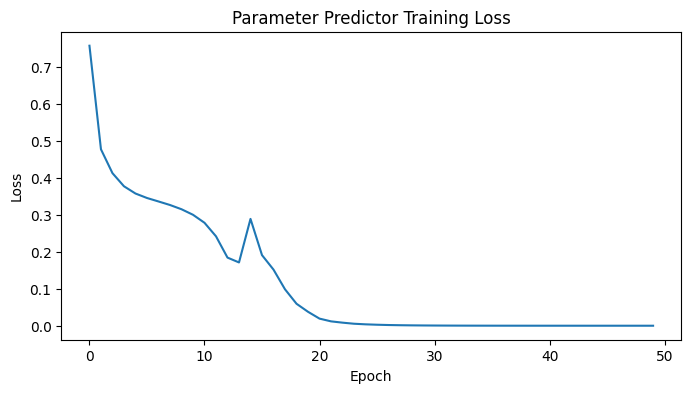


Testing predictions:
  Object 0: Predicted colour=ORANGE, Actual colour=ORANGE
  Object 1: Predicted colour=ORANGE, Actual colour=ORANGE
  Object 2: Predicted colour=GREEN, Actual colour=GREEN


In [10]:
from object_predictor import ParameterPredictor
from train import train_parameter_predictor
# 訓練 Parameter Predictor（以顏色參數為例）
try:
    if input_objs and output_objs and 'recolour' in ops:
        # 準備顏色參數的訓練資料
        recolour_inputs = []
        recolour_targets = []
        
        for in_obj, out_obj, op in zip(input_objs, output_objs, ops):
            if op == 'recolour':
                recolour_inputs.append(in_obj)
                recolour_targets.append(out_obj.colour_repr)  # 目標顏色
        
        if recolour_inputs:
            print(f"Train colour parameter predictor...")
            print(f"training number: {len(recolour_inputs)}")
            
            param_predictor = ParameterPredictor(N_DIMENSIONS, weights)
            losses = train_parameter_predictor(
                param_predictor, recolour_inputs, recolour_targets, n_epochs=50
            )
            
            # 繪製學習曲線
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Parameter Predictor Training Loss')
            plt.show()
            
            # 測試預測
            print("\nTesting predictions:")
            for i, (obj, target) in enumerate(zip(recolour_inputs[:3], recolour_targets[:3])):
                pred_vec = param_predictor.predict(obj)
                pred_colour_idx, _ = cleanup_colour(pred_vec)
                actual_colour_idx, _ = cleanup_colour(target)
                print(f"  Object {i}: Predicted colour={colour_tags[pred_colour_idx]}, Actual colour={colour_tags[actual_colour_idx]}")
        else:
            print("No training data for recolour operation.")
    else:
        print("Not enough training data.")
except Exception as e:
    print(f"Error occurred during training: {e}")

## Step 7: 完整流程示範

把所有步驟整合在一起，對一個新的測試輸入進行預測。

In [11]:
from solver import ARCVSASolver
# 測試完整求解器
solver = ARCVSASolver()

# 選擇一個任務
test_task_id = sample_task_id
test_task = challenges[test_task_id]

print(f"Task ID: {test_task_id}")
print(f"Training examples: {len(test_task['train'])}")
print()

# 訓練
success = solver.train(test_task)

if success and test_task.get('test'):
    print("\nTesting predictions:")
    test_input = test_task['test'][0]['input']
    test_objects = create_arc_objects(test_input)
    
    if test_objects:
        predictions = solver.predict_operations(test_objects)
        for i, (op, prob) in enumerate(predictions):
            print(f"  Object {i}: Operation={op}, Confidence={prob:.3f}")
    else:
        print("No objects detected in testing input.")

Task ID: 009d5c81
Training examples: 5

Extracted 10 object-operation pairs
Operation distribution: {'reshape': 2, 'recolour': 8}

weight of each pair:
  pair 1: colour=1.000, centre=0.000, shape=0.000
  pair 2: colour=0.325, centre=0.300, shape=0.375
  pair 3: colour=1.000, centre=0.000, shape=0.000
  pair 4: colour=0.420, centre=0.331, shape=0.249
  pair 5: colour=1.000, centre=0.000, shape=0.000
  pair 6: colour=0.424, centre=0.344, shape=0.232
  pair 7: colour=1.000, centre=0.000, shape=0.000
  pair 8: colour=0.393, centre=0.370, shape=0.237
  pair 9: colour=1.000, centre=0.000, shape=0.000
  pair 10: colour=0.395, centre=0.366, shape=0.239
global weight: colour=0.696, centre=0.171, shape=0.133

Training complete! Operation Predictors: ['reshape', 'recolour']

Testing predictions:
  Object 0: Operation=recolour, Confidence=1.000
  Object 1: Operation=recolour, Confidence=0.948


In [12]:
# 選擇一個訓練過的任務來測試
test_task_id = sample_task_id  # 使用第一個訓練任務
test_task = challenges[test_task_id]

print(f"Testing task ID: {test_task_id}")
print(f"Training examples: {len(test_task['train'])}")
print(f"Testing examples: {len(test_task['test'])}")

# 取得第一個測試範例
test_example = test_task['test'][0]
test_input = np.array(test_example['input'])
expected_output = np.array(solutions[test_task_id][0])

print(f"\nTesting input grid size: {test_input.shape}")
print(f"Expected output grid size: {expected_output.shape}")

Testing task ID: 009d5c81
Training examples: 5
Testing examples: 1

Testing input grid size: (14, 14)
Expected output grid size: (14, 14)


In [13]:
from solver import generate_output_grid_precise
# 使用精確方法生成預測輸出
predicted_output = generate_output_grid_precise(test_input, solver)

# 計算準確度
if predicted_output.shape == expected_output.shape:
    correct_pixels = np.sum(predicted_output == expected_output)
    total_pixels = expected_output.size
    accuracy = correct_pixels / total_pixels * 100
    print(f"Pixel accuracy: {accuracy:.2f}% ({correct_pixels}/{total_pixels})")
    
    # 檢查完全匹配
    if np.array_equal(predicted_output, expected_output):
        print("Totally correct! Predicted output matches expected output exactly!")
    else:
        print("Partially correct. There are differences between predicted and expected output.")
        
        # 顯示差異位置
        diff_positions = np.where(predicted_output != expected_output)
        n_diff = len(diff_positions[0])
        print(f"Number of differing pixels: {n_diff}")
        if n_diff <= 10:
            for i in range(n_diff):
                r, c = diff_positions[0][i], diff_positions[1][i]
                print(f"  Position ({r},{c}): Predicted={predicted_output[r,c]}, Expected={expected_output[r,c]}")
else:
    print(f"Grid size mismatch! Predicted: {predicted_output.shape}, Expected: {expected_output.shape}")

Pixel accuracy: 83.67% (164/196)
Partially correct. There are differences between predicted and expected output.
Number of differing pixels: 32


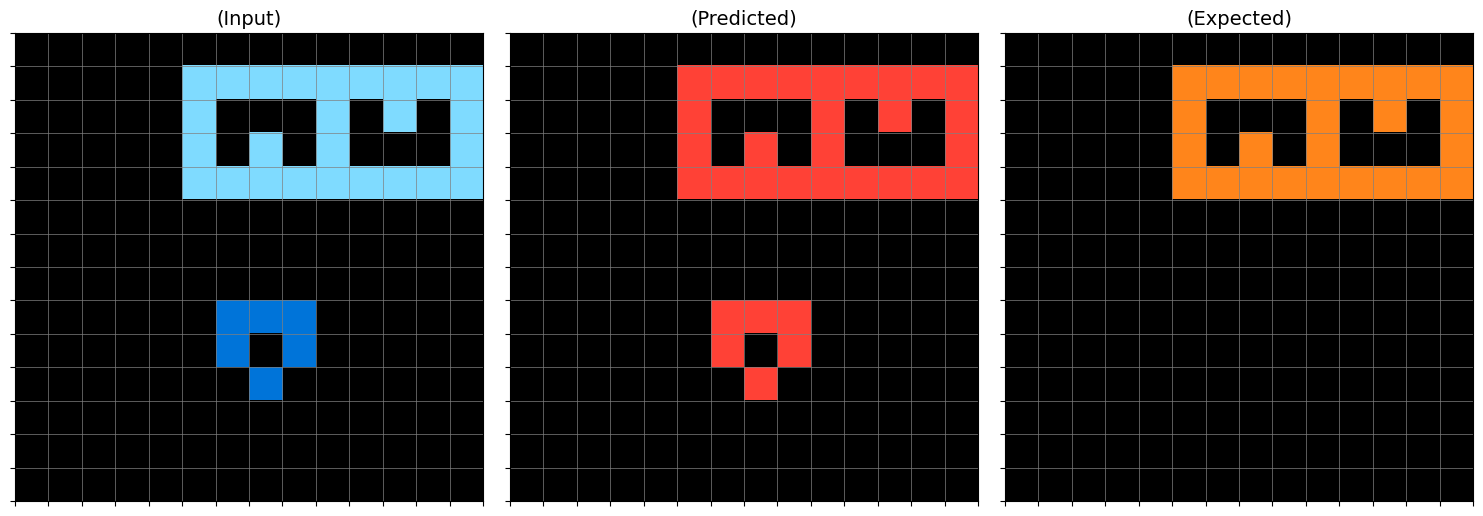


Overall pixel accuracy: 83.7%


In [14]:
# 視覺化比較：輸入 vs 預測輸出 vs 期望輸出
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 顏色映射
cmap = plt.cm.colors.ListedColormap([
    '#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
])
norm = plt.cm.colors.Normalize(vmin=0, vmax=9)

# 輸入
axes[0].imshow(test_input, cmap=cmap, norm=norm)
axes[0].set_title('(Input)', fontsize=14)
axes[0].grid(True, linewidth=0.5, color='gray')
axes[0].set_xticks(np.arange(-0.5, test_input.shape[1], 1))
axes[0].set_yticks(np.arange(-0.5, test_input.shape[0], 1))
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

# 預測輸出
axes[1].imshow(predicted_output, cmap=cmap, norm=norm)
axes[1].set_title('(Predicted)', fontsize=14)
axes[1].grid(True, linewidth=0.5, color='gray')
axes[1].set_xticks(np.arange(-0.5, predicted_output.shape[1], 1))
axes[1].set_yticks(np.arange(-0.5, predicted_output.shape[0], 1))
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

# 期望輸出
axes[2].imshow(expected_output, cmap=cmap, norm=norm)
axes[2].set_title('(Expected)', fontsize=14)
axes[2].grid(True, linewidth=0.5, color='gray')
axes[2].set_xticks(np.arange(-0.5, expected_output.shape[1], 1))
axes[2].set_yticks(np.arange(-0.5, expected_output.shape[0], 1))
axes[2].set_xticklabels([])
axes[2].set_yticklabels([])

plt.tight_layout()
plt.show()

if predicted_output.shape == expected_output.shape:
    accuracy = np.mean(predicted_output == expected_output) * 100
    print(f"\nOverall pixel accuracy: {accuracy:.1f}%")

In [15]:
from solver import evaluate_solver_on_task

# 在多個任務上評估
all_results = []
task_ids_to_test = list(challenges.keys())[:5]  # 測試前 5 個任務

for task_id in task_ids_to_test:
    print(f"\nEvaluating: {task_id}")
    
    # 為每個任務訓練一個新的 solver
    task = challenges[task_id]
    task_solver = ARCVSASolver()
    
    # 訓練
    success = task_solver.train(task)
    
    if success:
        # 評估
        results = evaluate_solver_on_task(task_solver, task_id, challenges, solutions)
        all_results.extend(results)
        
        for r in results:
            status = "Yes" if r['exact_match'] else f"No ({r['accuracy']*100:.1f}%)"
            print(f"  Test {r['test_idx']}: {status}")
    else:
        print("  Training failed for this task.")


Evaluating: 00576224
Extracted 7 object-operation pairs
Operation distribution: {'reshape': 1, 'recentre': 2, 'recolour': 4}

weight of each pair:
  pair 1: colour=1.000, centre=0.000, shape=0.000
  pair 2: colour=1.000, centre=0.000, shape=0.000
  pair 3: colour=1.000, centre=0.000, shape=0.000
  pair 4: colour=1.000, centre=0.000, shape=0.000
  pair 5: colour=1.000, centre=0.000, shape=0.000
  pair 6: colour=0.000, centre=0.000, shape=1.000
  pair 7: colour=0.333, centre=0.333, shape=0.333
global weight: colour=0.762, centre=0.048, shape=0.190

Training complete! Operation Predictors: ['reshape', 'recentre', 'recolour']
  Test 0: No (0.0%)

Evaluating: 007bbfb7
Extracted 9 object-operation pairs
Operation distribution: {'recentre': 7, 'identity': 2}

weight of each pair:
  pair 1: colour=0.330, centre=0.330, shape=0.339
  pair 2: colour=0.000, centre=1.000, shape=0.000
  pair 3: colour=0.000, centre=1.000, shape=0.000
  pair 4: colour=0.000, centre=1.000, shape=0.000
  pair 5: colou


Evaluation Summary
Total tasks: 5
Total test examples: 5
Exact matches: 0/5 (0.0%)
Average pixel accuracy: 50.7%


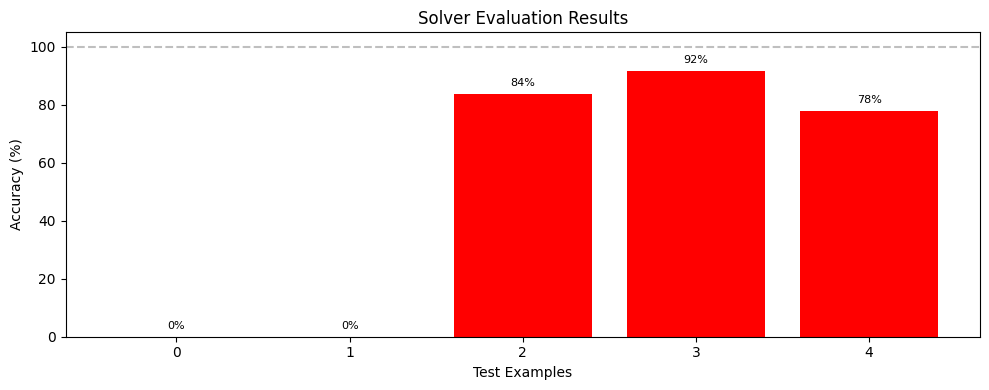

In [16]:
# 總結評估結果
if all_results:
    total_tasks = len(set(r['task_id'] for r in all_results))
    total_tests = len(all_results)
    exact_matches = sum(1 for r in all_results if r['exact_match'])
    avg_accuracy = np.mean([r['accuracy'] for r in all_results])
    
    print("\n" + "="*50)
    print("Evaluation Summary")
    print("="*50)
    print(f"Total tasks: {total_tasks}")
    print(f"Total test examples: {total_tests}")
    print(f"Exact matches: {exact_matches}/{total_tests} ({exact_matches/total_tests*100:.1f}%)")
    print(f"Average pixel accuracy: {avg_accuracy*100:.1f}%")
    print("="*50)
    
    # 視覺化結果
    fig, ax = plt.subplots(figsize=(10, 4))
    accuracies = [r['accuracy']*100 for r in all_results]
    task_labels = [f"{r['task_id'][:8]}...T{r['test_idx']}" for r in all_results]
    colors = ['green' if r['exact_match'] else 'red' for r in all_results]
    
    bars = ax.bar(range(len(accuracies)), accuracies, color=colors)
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Test Examples')
    ax.set_title('Solver Evaluation Results')
    ax.set_ylim(0, 105)
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
    
    # 添加準確度標籤
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{acc:.0f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No evaluation results available.")